# Alen Omarov

## RFM Analysis in Python - Customer Segmentation

## Research question/interests
The goal of this analysis is to identify customer segments for UK based retail company using RFM analysis and to understand how those groups differ from each other and try to predict customer lifetime value for the company.

Customer segmentation is the practice of grouping customers based on common characteristics. These customer segments are beneficial in marketing campaigns, in identifying potentially profitable customers, and in developing customer loyalty.

RFM (Recency-Frequency-Monetary) analysis is a simple technique for behaviour based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy. It is a handy method to find the best customers, understand their behavior and then run targeted marketing campaigns to increase sales, satisfaction and customer lifetime value.

### References
[RFM Analysis](https://www.geeksforgeeks.org/rfm-analysis-analysis-using-python/)
[Dealing with outliers](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/)

In [94]:
import pandas as pd
import datetime as dt
import seaborn as sns
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import squarify
import plotly.io as pio
palette = 'Set2'
import numpy as np

### Loading Data

In [28]:
data = pd.read_csv("../data/processed/new_data.csv")

In [29]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
406218,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
406219,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
406220,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
406221,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


### Exploring our Data

#### Variable Description

- InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product code that consists 5 digits.
- Description: Product name.
- Quantity: The quantities of each product per transaction.
- InvoiceDate: Represents the day and time when each transaction was generated.
- UnitPrice: Product price per unit.
- CustomerID: Customer number that consists 5 digits. Each customer has a unique customer ID.
- Country: Name of the country where each customer resides.

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406223 entries, 0 to 406222
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406223 non-null  object 
 1   StockCode    406223 non-null  object 
 2   Description  406223 non-null  object 
 3   Quantity     406223 non-null  int64  
 4   InvoiceDate  406223 non-null  object 
 5   UnitPrice    406223 non-null  float64
 6   CustomerID   406223 non-null  float64
 7   Country      406223 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.8+ MB


In [31]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406223.000000,406223.000000,406223.000000
mean,12.063138,3.463125,15287.550183
std,248.878146,69.366810,1713.683746
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


- As we can see, there are outliers in Quantity and UnitPrice that have to be handled.
- There are negative values in UnitPrice and Quantity because of cancelled orders.
- To get Total Price we should multiply these two columns

### Data Cleaning

Now I'm going to clean this data even further for my own purposes.

In [32]:
def outlier(data, variable, q1 = 0.25, q3 = 0.75):
    """
    Remove outliers from dataset based on q1 and q2

        Parameters
    ----------
    data : pandas DataFrame
        dataframe to clean

    variable: column of pandas Dataframe
        which column to clean

    q1: int
        first quartile

    q2: int
        second quartile

    Returns
    -------
    pandas DataFrame
        Cleaned dataset
    """
    df = data.copy()
    quartile1 = df[variable].quantile(q1)
    quartile3 = df[variable].quantile(q3)
    iqr = quartile3 - quartile1

    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit

    return df


def cleaning(data):
    """
    Remove cancelled Orders & Quantity from dataset, calculate Total Price, Replace Outliers

    Parameters
    ----------
    lst : pandas DataFrame
        dataframe to clean

    Returns
    -------
    pandas DataFrame
        Cleaned dataset
"""
    df = data.copy()

    #Dealing with cancelled orders
    df = df[~df['InvoiceNo'].str.contains('C', na = False)]
    df = df[df['Quantity'] > 0]

    #Calculating Total Price
    df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

    #Replacing Outliers
    outlier(df, "Quantity", q1 = 0.01, q3 = 0.99)
    outlier(df, "UnitPrice", q1 = 0.01, q3 = 0.99)

    return df

In [33]:
data = cleaning(data)
data[['Quantity', 'UnitPrice', 'TotalPrice']].describe()

,Quantity,UnitPrice,TotalPrice
count,397327.000000,397327.000000,397327.000000
mean,13.024685,3.118331,22.401355
std,180.554809,22.113310,309.286588
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


### RFM Analysis

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.
- Recency (R): Who have purchased recently? Number of days since last purchase
- Frequency (F): Who has purchased frequently? The total number of purchases
- Monetary Value(M): Who has high purchase amount? The total money customer spent

#### Recency


To calculate ours recency scores, we need to find the latest date in this dataset and take it as a point from which we will calculate how many days ago was the customer's last purchase.

In [34]:
#create a new column called date which contains the date of invoice only
#because InvoiceDate in String format, but we need it in the date format
data['date'] = pd.DatetimeIndex(data['InvoiceDate']).date
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01
...,...,...,...,...,...,...,...,...,...,...
406218,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20,2011-12-09
406219,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60,2011-12-09
406220,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60,2011-12-09
406221,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60,2011-12-09


In [35]:
#last date available in our dataset
print(data['date'].max())

2011-12-09


The latest date is 2011-12-09

In [36]:
latest = dt.date(2011, 12, 9)
print(latest)

2011-12-09


In [37]:
#I'm grouping by customerID and check last date of purchase
recency = data.groupby(by='CustomerID', as_index=False)['date'].max()
recency.columns = ['CustomerID','LastPurchase']
recency

,CustomerID,LastPurchase
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02
...,...,...
4334,18280.0,2011-03-07
4335,18281.0,2011-06-12
4336,18282.0,2011-12-02
4337,18283.0,2011-12-06


In [38]:
#calculate recency
recency['Recency'] = recency['LastPurchase'].apply(lambda x: (latest - x).days)
recency.drop('LastPurchase',axis=1,inplace=True)
recency

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
...,...,...
4334,18280.0,277
4335,18281.0,180
4336,18282.0,7
4337,18283.0,3


#### Frequency

Frequency helps us to know how many times a customer purchased from the store. We need to check how many invoices are registered by the same customer.

In [39]:
# First of all we will drop all duplicates
df_freq = data.copy()
df_freq.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency = df_freq.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency.columns = ['CustomerID','Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


#### Monetary

Monetary attribute answers the question: How much money did the customer spent over time? To do that, first, we will create a new column total cost to have the total price per invoice.

In [40]:
monetary = data.groupby(by='CustomerID',as_index=False).agg({'TotalPrice': 'sum'})
monetary.columns = ['CustomerID','Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4290.20
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Merging to get RFM Table

In [41]:
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,2,7,4290.20
2,12348.0,75,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,310,1,334.40


#### RFM Scores

In [42]:
def get_rfm_scores(data):
    """
    Calculate RFM Scores based on values of Recency, Frequency, Monetary

    Parameters
    ----------
    data : pandas DataFrame
        dataframe on which we want to calculate RFM Scores

    Returns
    -------
    pandas DataFrame
        dataframe with RFM Scores


    """

    df = data.copy()
    df['recency_score'] = pd.qcut(df['Recency'],5,labels = [5, 4, 3, 2, 1])
    df['frequency_score'] = pd.qcut(df['Frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
    df['monetary_score'] = pd.qcut(df['Monetary'], 5, labels = [1, 2, 3, 4, 5])
    df['RFM_SCORE'] = (df['recency_score'].astype(str) + df['frequency_score'].astype(str))

    return df

rfm = get_rfm_scores(rfm)
rfm

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,12346.0,325,1,77183.60,1,1,5,11
1,12347.0,2,7,4290.20,5,5,5,55
2,12348.0,75,4,1797.24,2,4,4,24
3,12349.0,18,1,1757.55,4,1,4,41
4,12350.0,310,1,334.40,1,1,2,11
...,...,...,...,...,...,...,...,...
4334,18280.0,277,1,180.60,1,2,1,12
4335,18281.0,180,1,80.82,1,2,1,12
4336,18282.0,7,2,178.05,5,3,1,53
4337,18283.0,3,16,2094.88,5,5,5,55


In [43]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346.0,325,1,77183.60,1,1,5,11,hibernating
1,12347.0,2,7,4290.20,5,5,5,55,champions
2,12348.0,75,4,1797.24,2,4,4,24,at_Risk
3,12349.0,18,1,1757.55,4,1,4,41,promising
4,12350.0,310,1,334.40,1,1,2,11,hibernating


| Id  | Segment | Description | R   | F   | M   |
|-----|---------|-------------|-----|-----|-----|
| 1   | Champions   | Reward these users. They promote your products and they can be early adopters for your new launches       | 4-5 | 4-5 | 4-5 |
| 2   | Loyal Customers    | These users are responsive to your promotions. Suggest higher-value products to them. Also, leverage them for reviews        | 4-5 | 1-5 | 1-5 |
| 3   | Potential Loyalist   | Engage them with long-term offers like loyalty programs or membership rewards. Suggest other categories of products to them       | 3-5 | 1-4 | 1-4 |
| 4   | New Customers   | For new users, make their onboarding experience smooth and provide assistance when needed       | 4-5 | 0-1 | 0-1 |
| 5   | Promising   | Convert them into loyal customers by creating brand awareness and giving free trials       | 3-4 | 0-1 | 0-1 |
| 6   | Needs Attention   | You need to bring back these customers. Provide limited period offers and recommend products based on their purchase history (Above average recency, frequency & monetary values)       | 2-3 | 2-3 | 2-3 |
| 7   | About To Sleep   | Swoop in before you lose them. Recommend popular products and provide membership discounts. Reactivate them as soon as possible (Below average recency, frequency & monetary values)	       | 2-3 | 0-2 | 0-2 |
| 8   | At Risk (Price Sensitive)   | These are users looking for the best deal. Recommend highest-rated products and send discount communication (Spent big money, purchased often but long time ago)       | 0-3 | 1-5 | 1-5 |
| 9   | Can`t Lose Them   | Listen to their feedback, suggest newer products and make them stick to your platform (Made big purchases and often, but long time ago)       | 0-1 | 4-5 | 4-5 |
| 10  | Hibernating   | Recommend relevant products from other categories and provide personalized offers (Low spenders, low frequency, purchased long time ago)       | 0-2 | 0-2 | 0-2 |

In [44]:
rfm[['Recency','Monetary','Frequency','segment']]\
.groupby('segment')\
.agg({'mean','std','max','min'})

Recency                           Monetary             \
                           std  max min        mean           std        max   
segment                                                                        
about_to_sleep       10.943474   71  33   52.312500    533.269005    6207.67   
at_Risk              68.618828  373  72  152.785835   2561.959082   44534.30   
cant_loose           65.250378  372  72  131.968254   2084.963054   10254.18   
champions             3.683300   12   0    5.361769  20334.484637  280065.17   
hibernating          92.013560  373  72  216.605042   2419.680843   77183.60   
loyal_customers      15.577050   71  14   32.608059   6001.962699  124844.93   
need_attention       11.552074   71  33   51.427807   1102.392867   12601.83   
new_customers         3.902112   12   0    6.428571    570.778807    3861.00   
potential_loyalists   9.338808   32   0   16.398760   7656.326604  168472.50   
promising             5.238115   32  14   22.421053    241.199688    1757.55   

                                          Frequency                      
                        min         mean        std  max min       mean  
segment                                                                  
about_to_sleep         6.20   471.007443   0.368913    2   1   1.161932  
at_Risk               52.00  1082.825347   0.954415    6   2   2.878583  
cant_loose            70.02  2792.147937   4.289630   34   6   8.380952  
champions            201.12  6851.544692  16.477052  210   3  12.415482  
hibernating            3.75   487.986585   0.302492    2   1   1.101774  
loyal_customers       36.56  2860.033017   4.545669   63   3   6.479853  
need_attention         6.90   895.799251   0.470081    3   2   2.326203  
new_customers         89.94   387.348571   0.000000    1   1   1.000000  
potential_loyalists   20.80  1040.163326   0.651401    3   1   2.010331  
promising              0.00   290.496316   0.000000    1   1   1.000000

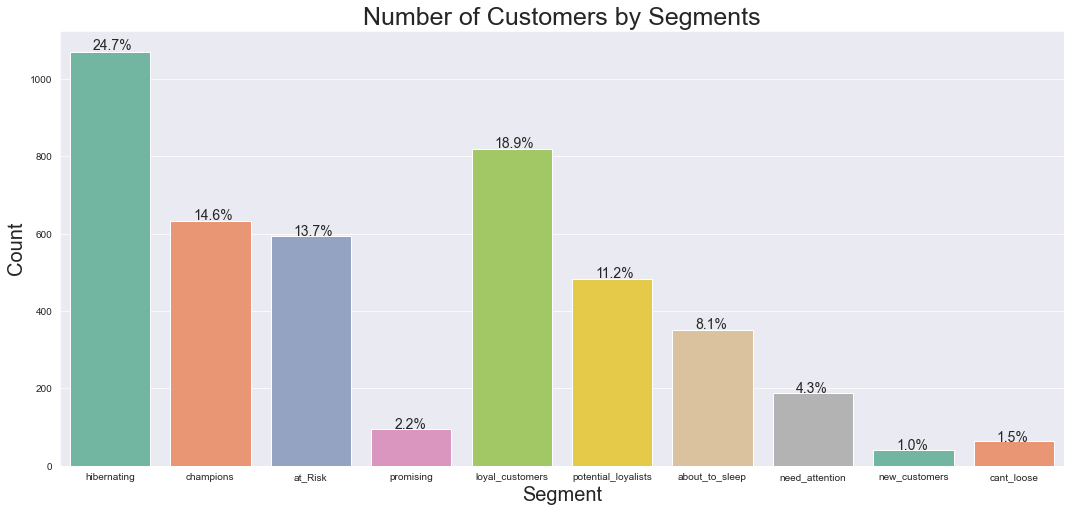

In [100]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = rfm,
                   x = 'segment',
                   palette = palette)
total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 25)
plt.xlabel('Segment', size = 20)
plt.ylabel('Count', size = 20)
plt.show()

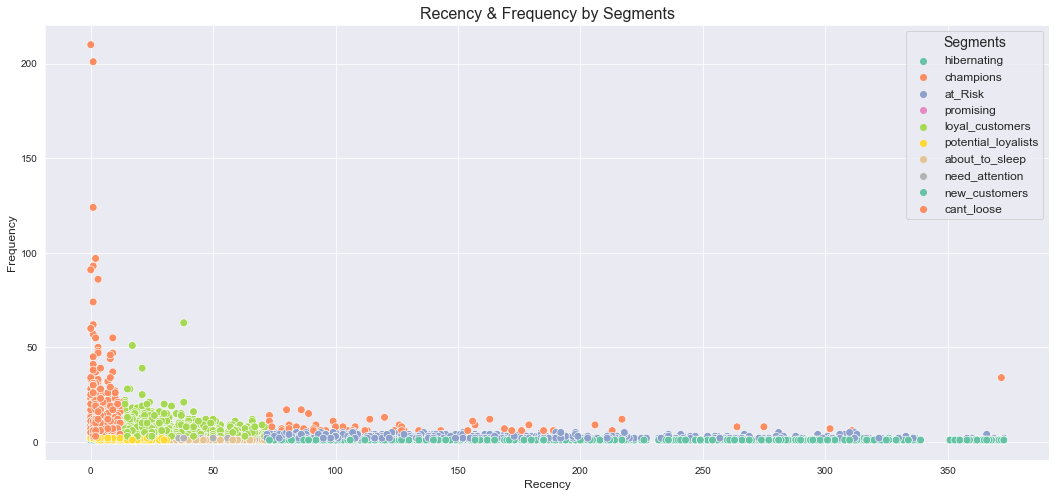

In [106]:
plt.figure(figsize = (18, 8))
sns.scatterplot(data = rfm,
                x = 'Recency',
                y = 'Frequency',
                hue ='segment',
                palette = palette,
                s = 60)
plt.title('Recency & Frequency by Segments', size = 16)
plt.xlabel('Recency', size = 12)
plt.ylabel('Frequency', size = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.legend(loc = 'best', fontsize = 12,
           title = 'Segments',title_fontsize=14)
plt.show()


/var/folders/15/r0q176ls4bs6m9xqgbmn_hdw0000gn/T/ipykernel_65601/2909940835.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




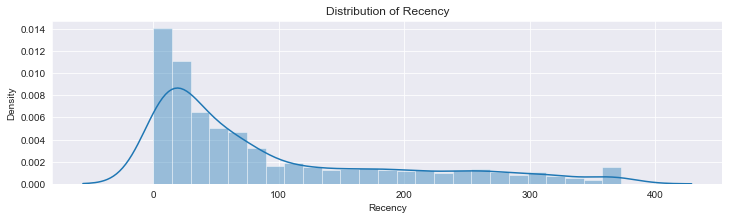

/var/folders/15/r0q176ls4bs6m9xqgbmn_hdw0000gn/T/ipykernel_65601/2909940835.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




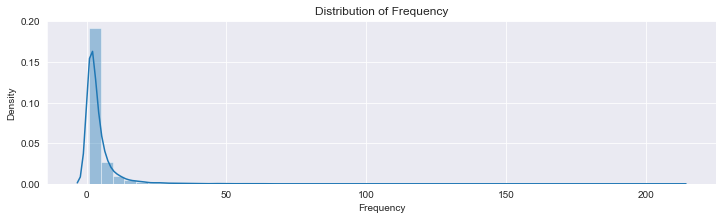

/var/folders/15/r0q176ls4bs6m9xqgbmn_hdw0000gn/T/ipykernel_65601/2909940835.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




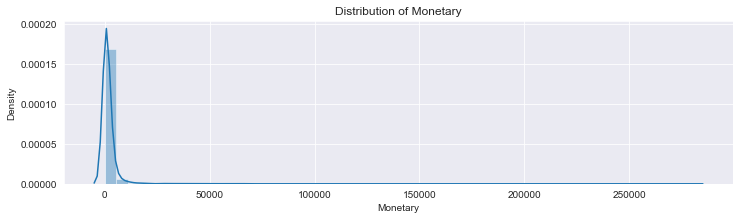

In [118]:
colnames = ['Recency', 'Frequency', 'Monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(rfm[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

In [51]:
#hist_data = [rfm['Recency'], rfm['Frequency']]

# Create distplot with custom bin_size
#fig = ff.create_distplot(hist_data, rfm['segment'], bin_size=.2)
#fig.show()